In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from saif.crs_model.peakdetector import pk_indxs
plt.style.use('ggplot')

%matplotlib inline

In [2]:
from saif.scinet.dataset import EarthquakeDataset
import saif.scinet.model as scinet
from torch.utils.data import DataLoader

In [3]:
import pandas as pd
seismic = pd.read_csv("../../data/02_intermediate/seismic.csv", index_col=0)
pressure = pd.read_csv("../../data/02_intermediate/pressure.csv", index_col=0)

Right now, input_len must match output_len

In [4]:
input_len = 64
output_len = 8

In [5]:
dset = EarthquakeDataset(
    seismic, pressure, input_len, horizon=output_len,
    target_fn=lambda x : x
)

In [7]:
from sklearn.preprocessing import StandardScaler, RobustScaler

In [8]:
dset.X = torch.FloatTensor(RobustScaler().fit_transform(dset.X))
dset.Y = torch.FloatTensor(RobustScaler().fit_transform(dset.Y[:, None])).squeeze()

In [9]:
torch.manual_seed(0)

data_loader = DataLoader(
    dset,
    batch_size=32,
    shuffle=True,
    num_workers=1
)

In [28]:
class SimpleSCINet(nn.Module):
    def __init__(
        self, 
        input_len, output_len,
        input_dim, num_levels, kernel_size, dropout, groups, hidden_size
    ):
        super().__init__()
        
        self.input_len = input_len
        self.output_len = output_len
        self.input_dim = input_dim
        self.hidden_size = hidden_size
        self.num_levels = num_levels
        self.groups = groups
        self.kernel_size = kernel_size
        self.dropout = dropout
        
        self.bn1 = nn.BatchNorm1d(self.input_dim)
        self.bn2 = nn.BatchNorm1d(self.input_dim)
        
        self.block1 = scinet.EncoderTree(
            in_planes=self.input_dim,
            num_levels=self.num_levels,
            kernel_size=self.kernel_size,
            dropout=self.dropout,
            groups=self.groups,
            hidden_size=self.hidden_size,
            INN=True
        )
        
        self.time_projector = nn.Conv1d(
            self.input_len, self.output_len,
            kernel_size=1, stride=1, bias=False
        )
        
        self.channel_projector = nn.Conv1d(
            self.input_dim, 1, kernel_size=1, stride=1, bias=False
        )
    
    def forward(self, x):
        out = x.permute(0, 2, 1)
        out = self.bn1(out)
        out = out.permute(0, 2, 1)
        
        out = self.block1(out)
        out += out
        
        out = F.relu(out)
        out = self.time_projector(out)
        
        out = out.permute(0, 2, 1)
        out = self.bn2(out)
        out = F.relu(out)
        
        out = self.channel_projector(out).squeeze(1)
        
        return out

In [34]:
input_dim = dset.X.shape[1]
num_levels = 3 # number of levels in the scinet tree
kernel_size = 3 # kernel size for the conv1D operations
dropout = 0.5 # dropout regularization params
groups = 1 # number of groups in the conv1D operation
hidden_size = 2 # scaling factor for the hidden dimension

In [35]:
lr = 1e-3 # learning rate
n_epoch = 64 # number of epochs

In [36]:
from tqdm.notebook import tqdm

In [37]:
torch.manual_seed(0)

model = SimpleSCINet(
    input_len, output_len,
    input_dim, num_levels, kernel_size, 
    dropout, groups, hidden_size
)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

loss_vals = []

for epoch in tqdm(range(n_epoch)):
    batch_loss_vals = []
    for (batch_x, batch_y) in data_loader:
        optimizer.zero_grad()
        
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        batch_loss_vals.append(loss.item())
    
    loss_vals.append(np.mean(batch_loss_vals))

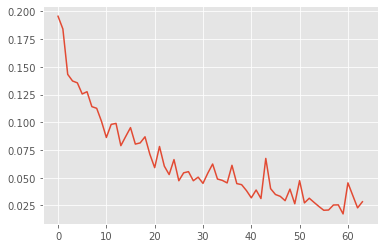

In [38]:
plt.plot(loss_vals)